## Emergency vs Non-Emergency Vehicle Classification

- Fatalities due to traffic delays of emergency vehicles such as ambulance & fire brigade is a huge problem. In daily life, we often see that emergency vehicles face difficulty in passing through traffic. So differentiating a vehicle into an emergency and non emergency category can be an important component in traffic monitoring as well as self drive car systems as reaching on time to their destination is critical for these services.

- In this problem, you will be working on classifying vehicle images as either belonging to the emergency vehicle or non-emergency vehicle category. For the same, you are provided with the train and the test dataset. Emergency vehicles usually includes police cars, ambulance and fire brigades.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/08/Emgen.jpg">

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from os import listdir
import skimage.exposure

In [45]:
train=pd.read_csv("train/train.csv")

In [46]:
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [47]:
train["emergency_or_not"].value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

In [48]:
train.shape

(1646, 2)

In [49]:
image=cv2.imread("train/images/1503.jpg")
image.shape

(224, 224, 3)

In [50]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["emergency_or_not"],shuffle=True)

In [51]:
(X_train["emergency_or_not"].value_counts()/len(X_train))*100

0    58.609048
1    41.390952
Name: emergency_or_not, dtype: float64

In [52]:
train_datagen=ImageDataGenerator(rescale=1./255,)

In [53]:
train_generator=train_datagen.flow_from_dataframe(
                                                        dataframe=X_train,
                                                        directory="train/images",
                                                        x_col="image_names",
                                                        y_col="emergency_or_not",
                                                        batch_size=16,
                                                        seed=42,
                                                        shuffle=True,
                                                        class_mode="raw",
                                                        target_size=(224, 224))

Found 1481 validated image filenames.


In [54]:
valid_datagen=ImageDataGenerator(rescale=1./255.,)
valid_generator=valid_datagen.flow_from_dataframe(
                                                    dataframe=X_valid,
                                                     directory="train/images",
                                                        x_col="image_names",
                                                        y_col="emergency_or_not",
                                                    batch_size=16,
                                                    seed=42,
                                                    shuffle=True,
                                                     class_mode="raw",
                                                    target_size=(224, 224))

Found 165 validated image filenames.


In [55]:
## showing some image from training
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

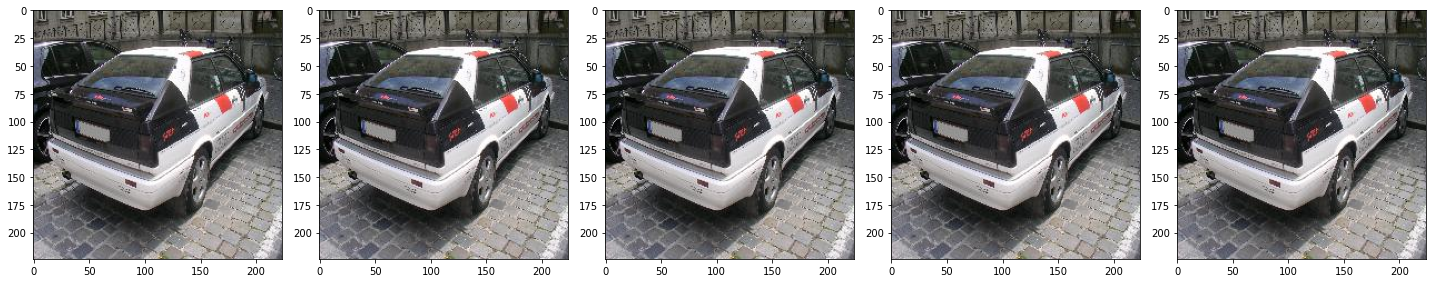

In [56]:
images = [train_generator[0][0][0] for i in range(5)]
plotImages(images)

## Using CNN

In [19]:
from tensorflow.keras.layers import Conv2D
import tensorflow as tf

In [20]:
# Part 2 - Building the CNN

# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - # Adding a first convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', input_shape=[299,299, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

###ann layer
tf.keras.layers.Dropout(0.5)
# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
tf.keras.layers.Dropout(0.5)

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [21]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
# Training the CNN on the Training set and evaluating it on the Test set
cnn.fit(x = train_generator, validation_data =valid_generator, epochs = 2)

Epoch 1/2
93/93 [==============================] - 184s 2s/step - loss: 1.7005 - accuracy: 0.5799 - val_loss: 0.6448 - val_accuracy: 0.6606
Epoch 2/2
93/93 [==============================] - 174s 2s/step - loss: 0.5137 - accuracy: 0.7424 - val_loss: 0.5322 - val_accuracy: 0.7455


## Using Mobile_Net

In [59]:
import tensorflow_hub as hub

In [60]:
BATCH_SIZE = 5
IMG_SHAPE = 224 # match image dimension to mobile net input keep smae

In [61]:
# getting MobileNet
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobile_net = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

In [62]:
mobile_net.trainable = False

In [63]:
model = tf.keras.models.Sequential([
    mobile_net,
    ### ann layer
    tf.keras.layers.Dense(1, activation='sigmoid') #[0, 1] or [1, 0]
    ])

In [64]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [65]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=valid_generator
    )

C:\Users\Dell\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
93/93 [==============================] - 80s 816ms/step - loss: 0.4355 - accuracy: 0.7980 - val_loss: 0.2024 - val_accuracy: 0.9273
Epoch 2/5
93/93 [==============================] - 79s 851ms/step - loss: 0.1908 - accuracy: 0.9280 - val_loss: 0.1882 - val_accuracy: 0.9455
Epoch 3/5
93/93 [==============================] - 81s 873ms/step - loss: 0.1513 - accuracy: 0.9430 - val_loss: 0.1614 - val_accuracy: 0.9576
Epoch 4/5
93/93 [==============================] - 81s 875ms/step - loss: 0.1557 - accuracy: 0.9372 - val_loss: 0.1501 - val_accuracy: 0.9636
Epoch 5/5
93/93 [==============================] - 78s 835ms/step - loss: 0.1274 - accuracy: 0.9564 - val_loss: 0.1444 - val_accuracy: 0.9576


## Simple CNN 0.74 But Mobilenet 0.95

In [75]:
#save model
from tensorflow.keras.models import load_model
model.save('vechile.h5')

In [77]:
#load model
model_vechile = load_model(('vechile.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

Normal Vechicle


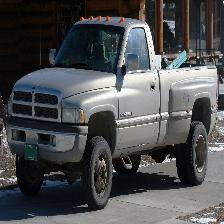

In [95]:
# Part 4 - Making a single prediction
from IPython.display import Image
import numpy as np
from tensorflow.keras.preprocessing import image
image_name = '2332.jpg'
test_image = image.load_img(image_name, target_size = (224,224)) #formobilenet
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model_vechile.predict(test_image)
# print(result)
if result > 0.5:
    print("Energence Vechicle")
else:
    print("Normal Vechicle")

Image(filename=image_name) 